In [151]:
import os
import pandas as pd
from ggplot import *
import numpy as np
import matplotlib.pyplot as plt

import seasonal
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

# Data Location within CC DS
data_location = os.path.join("..","data","external")


#######################################################
# Helpful Functions I may need

def CAGR(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    first = df.head(1)
    last = df.tail(1)
    periods = (last.Date-first.Date).astype('timedelta64[m]')
    
    return periods



#######################################################
# Create Lists of Columns for Subsetting Data for Analysis
# Create Mapping of Column Names for Cleanliness
#


compset_oar_list = ['Date',
                   'Region',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

compset_oar_mapping = {
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR_TRANS',
                   'ADR-Grp.':'ADR_GRP',
                   'ADR-Cont.':'ADR_CONT',
                   'ADR-Total':'ADR_TOTAL',
                   'RevPAR-Trans.':'RevPAR_TRANS',
                   'RevPAR-Grp.':'RevPAR_GRP',
                   'RevPAR-Cont.':'RevPAR_CONT',
                    'RevPAR-Total':'RevPAR_TOTAL'
                    }


m_cnty_oar_list = ['Year',
                   'Month',
                   'Occ-Trans.',
                   'Occ-Grp.',
                   'Occ-Cont.',
                   'Occ-Total',
                   'ADR-Trans.',
                   'ADR-Grp.',
                   'ADR-Cont.',
                   'ADR-Total',
                   'RevPAR-Trans.',
                   'RevPAR-Grp.',
                   'RevPAR-Cont.',
                    'RevPAR-Total']

m_cnty_oar_mapping = {
                   'Occ-Trans.':'OCC_TRANS',
                   'Occ-Grp.':'OCC_GRP',
                   'Occ-Cont.':'OCC_CONT',
                   'Occ-Total':'OCC_TOTAL',
                   'ADR-Trans.':'ADR_TRANS',
                   'ADR-Grp.':'ADR_GRP',
                   'ADR-Cont.':'ADR_CONT',
                   'ADR-Total':'ADR_TOTAL',
                   'RevPAR-Trans.':'RevPAR_TRANS',
                   'RevPAR-Grp.':'RevPAR_GRP',
                   'RevPAR-Cont.':'RevPAR_CONT',
                    'RevPAR-Total':'RevPAR_TOTAL'
                }



region_mapping = {'Long Beach/Torrance':'LBT',
                   'Sonoma County, CA':'SON C',
                   'Napa County, CA':'NAPA C',
                   'Santa Barbara County, CA': 'SB',
                   'Monterey County, CA':'MONT',
                   'City of Monterey, CA':"CMONT",
                   'San Diego, CA':'SD',
                   'Santa Barbara/Santa Maria, CA':'SBSM',
                   'San Francisco/San Mateo, CA':'SF',
                   'South Lake Tahoe, CA':'SLT',
                   'Laguna Beach, CA':'LAG',
                   'San Jose-Santa Cruz, CA':'SJ',
                   'Palm Springs, CA':'PS',
                   'Napa Valley, CA':'NV',
                   'Newport Beach/Dana Point, CA':'NPB'}



# Read in Monterey County XLS
#
# Documentation for Monterey County XLS goes here...
file_path = os.path.join(data_location, "Monterey-County-City-STR-ALL.xlsx")
m_cnty = pd.read_excel(file_path, sheetname = "County of Monterey 05-16 Seg")
m_cty = pd.read_excel(file_path, sheetname = "City of Monterey 00-16 Agg")

# Read in Compset data
file_path = os.path.join(data_location, "Comp-Set-STR-ALL.xlsx")
compset_hm = pd.read_excel(file_path, sheetname = "Comp-Set OCC-ADR-RevPARv2")

# Read in Budget data
file_path = os.path.join(data_location, "TID_BUDGET.xlsx")
budget = pd.read_excel(file_path, sheetname = "income")


In [158]:
###################################################
# Process monterey_county
m_cnty_v1 = m_cnty[m_cnty_oar_list]
m_cnty_v2 = m_cnty_v1.rename(columns=m_cnty_oar_mapping)


m_cnty_v2['Month'] = m_cnty_v2['Month'].apply(str)
m_cnty_v2['Year'] = m_cnty_v2['Year'].apply(str)
m_cnty_v2['Date'] = m_cnty_v2['Year'] + "-" + m_cnty['Month']
m_cnty_v2['Date'] = pd.to_datetime(m_cnty_v2['Date'], format = "%Y-%b")
m_cnty_v2['Month'] = m_cnty_v2['Date'].apply(lambda x: x.month)

m_cnty_v2['Region'] = 'Monterey County, CA'

###################################################
# Process compset data
compset_hm_v1 = compset_hm = compset_hm[compset_oar_list]
compset_hm_v2 = compset_hm_v1.rename(columns=compset_oar_mapping)

#Date & Time Manipulation
compset_hm_v2['Date'] = pd.to_datetime(compset_hm_v2['Date'])
compset_hm_v2['Month'] = compset_hm_v2['Date'].apply(lambda x: x.month)
compset_hm_v2['Year'] = compset_hm_v2['Date'].apply(lambda x: x.year)

#String Manipulation
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('+','')
compset_hm_v2['Region'] = compset_hm_v2['Region'].str.replace('San Jose/Santa Cruz, CA','San Jose-Santa Cruz, CA')

#Leave out Monterey County For Duplicate Data
compset_hm_v2 = compset_hm_v2[compset_hm_v2['Region'] != "Monterey County, CA"]


In [179]:
###############################################
# Combine datasets for Hotel Metrics 
tot_set = compset_hm_v2.append(m_cnty_v2)

# Sort before Calculations (Do I need to do this?)
tot_set = tot_set[tot_set['Date'] > '2011-06-01']
tot_set = tot_set.sort_values(by=['Date'], ascending = True)
tot_set = tot_set.round(2)
tot_set = tot_set.reset_index()

#String Manipulation
tot_set = tot_set.replace({'Region':region_mapping})

##############################################
# Calculate metrics, in this case, simple growth MOM & YOY
# May consider YTD

#Average Daily Rate  MOM & YOY
tot_set['ADR_GRP_MOM'] =     tot_set.groupby(['Region'])['ADR_GRP'].pct_change(1)
tot_set['ADR_TRANS_MOM'] =   tot_set.groupby(['Region'])['ADR_TRANS'].pct_change(1)
tot_set['ADR_TOTAL_MOM'] =   tot_set.groupby(['Region'])['ADR_TOTAL'].pct_change(1)

tot_set['ADR_GRP_ANN'] =     tot_set.groupby(['Region'])['ADR_GRP'].pct_change(12)
tot_set['ADR_TRANS_ANN'] =   tot_set.groupby(['Region'])['ADR_TRANS'].pct_change(12)
tot_set['ADR_TOTAL_ANN'] =   tot_set.groupby(['Region'])['ADR_TOTAL'].pct_change(12)


#Occupancy MOM & YOY
tot_set['OCC_GRP_MOM'] =     tot_set.groupby(['Region'])['OCC_GRP'].pct_change(1)
tot_set['OCC_TRANS_MOM'] =   tot_set.groupby(['Region'])['OCC_TRANS'].pct_change(1)
tot_set['OCC_TOTAL_MOM'] =   tot_set.groupby(['Region'])['OCC_TOTAL'].pct_change(1)

tot_set['OCC_GRP_ANN'] =     tot_set.groupby(['Region'])['OCC_GRP'].pct_change(12)
tot_set['OCC_TRANS_ANN'] =   tot_set.groupby(['Region'])['OCC_TRANS'].pct_change(12)
tot_set['OCC_TOTAL_ANN'] =   tot_set.groupby(['Region'])['OCC_TOTAL'].pct_change(12)


#RevPar MOM & YOY
tot_set['RevPAR_GRP_MOM'] =     tot_set.groupby(['Region'])['RevPAR_GRP'].pct_change(1)
tot_set['RevPAR_TRANS_MOM'] =   tot_set.groupby(['Region'])['RevPAR_TRANS'].pct_change(1)
tot_set['RevPAR_TOTAL_MOM'] =   tot_set.groupby(['Region'])['RevPAR_TOTAL'].pct_change(1)

tot_set['RevPAR_GRP_ANN'] =     tot_set.groupby(['Region'])['RevPAR_GRP'].pct_change(12)
tot_set['RevPAR_TRANS_ANN'] =   tot_set.groupby(['Region'])['RevPAR_TRANS'].pct_change(12)
tot_set['RevPAR_TOTAL_ANN'] =   tot_set.groupby(['Region'])['RevPAR_TOTAL'].pct_change(12)



#RevPAR Rolling Mean
tot_set['RevPAR_GRP_MOM_ROLL_QTR'] = tot_set.groupby(['Region'])['RevPAR_GRP_MOM'].apply(pd.rolling_mean, 3)









In [154]:
tot_set

,index,ADR_CONT,ADR_GRP,ADR_TOTAL,ADR_TRANS,Date,Month,OCC_CONT,OCC_GRP,OCC_TOTAL,...,OCC_GRP_ANN,OCC_TRANS_ANN,OCC_TOTAL_ANN,RevPAR_GRP_MOM,RevPAR_TRANS_MOM,RevPAR_TOTAL_MOM,RevPAR_GRP_ANN,RevPAR_TRANS_ANN,RevPAR_TOTAL_ANN,RevPAR_GRP_MOM_ROLL_QTR
0,337,164.05,243.59,316.34,344.08,2015-07-01,7,0.03,22.06,80.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,338,103.73,182.29,189.19,194.73,2015-07-01,7,2.07,23.53,86.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,339,138.10,188.32,217.58,224.66,2015-07-01,7,2.13,11.79,86.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,340,163.69,215.68,232.55,242.52,2015-07-01,7,5.70,16.60,89.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,341,65.95,183.09,166.31,163.12,2015-07-01,7,0.83,17.53,84.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,342,0.00,141.96,136.36,134.40,2015-07-01,7,0.00,18.62,71.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,343,265.55,297.95,439.15,467.39,2015-07-01,7,2.46,11.34,85.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,344,83.99,210.53,253.53,275.44,2015-07-01,7,3.57,18.67,86.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,345,65.06,86.77,108.42,115.98,2015-07-01,7,1.07,11.77,52.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,346,123.21,148.18,173.84,184.39,2015-07-01,7,2.32,20.54,83.87,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


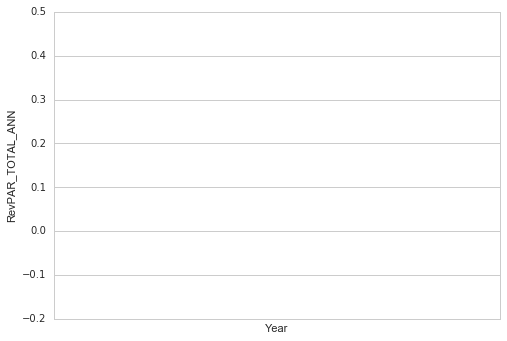

In [188]:
##################################################
# Let's visualize this data for output to Tammy & Rob
# 

#Getting a feel for it
viz_set = tot_set
viz_set['Date'] = pd.to_datetime(viz_set['Date'])
viz_set['Month-Year'] = viz_set['Date'].apply(lambda x: str(x.month) + "-" + str(x.year))
#viz_set = viz_set.set_index(viz_set['Date'])

#Alright Let's Subset into individual Charts
unique_areas = viz_set['Region'].unique()
plots = {}


# Lets create some PDFs to Export out
for area in unique_areas:
    temp_data = viz_set[viz_set['Region'] == area]
    sns.barplot(x="Region",y="RevPAR_GRP_ANN",\
              data=temp_data)
    
sns.boxplot(x="Year",y="OCC_TOTAL_ANN",data=viz_set[viz_set['Region']=="MONT"])
sns.tsplot(data = viz_set[viz_set['Region']=="MONT"],time="Year",\
           value="RevPAR_TOTAL_ANN")

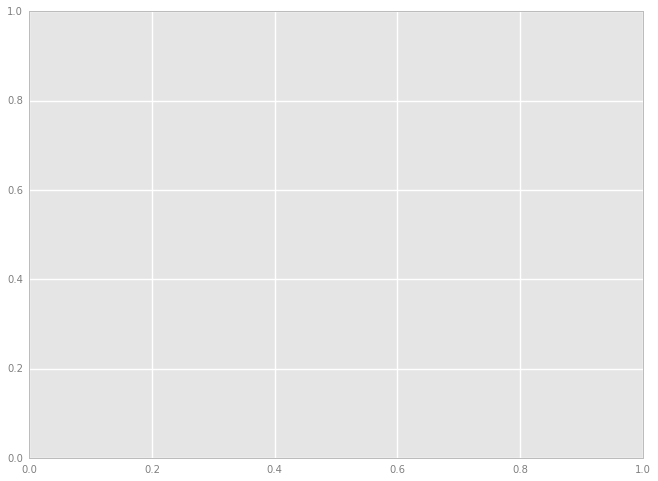

In [156]:

plot = ggplot(aes(x='Date',y='RevPAR_GRP_ANN',color='Region'), viz_set) \
+ geom_line() \
+ geom_hline(yintercept=0,color='black',size=1.7) \
+ scale_x_date(labels='%m-%Y',breaks=date_breaks('week')) \
+ scale_y_continuous(labels='Percent')




#Alright Let's Subset into individual Charts
unique_areas = viz_set['Region'].unique()
plots = {}


# Lets create some PDFs to Export out
for area in unique_areas:
    temp_data = viz_set[viz_set['Region'] == area]
    plot = ggplot(aes(x='Month-Year',y='RevPAR_GRP_ANN'), temp_data) \
    + geom_line() \
    + ggtitle(('Group RevPAR MOM Change: %s') % area) \
    
    
    plots[area] = plot
    try:
        plot.show()
    except:
        "Not correct"
        


In [157]:
viz_set.dtypes

index                               int64
ADR_CONT                          float64
ADR_GRP                           float64
ADR_TOTAL                         float64
ADR_TRANS                         float64
Date                       datetime64[ns]
Month                               int64
OCC_CONT                          float64
OCC_GRP                           float64
OCC_TOTAL                         float64
OCC_TRANS                         float64
Region                             object
RevPAR_CONT                       float64
RevPAR_GRP                        float64
RevPAR_TOTAL                      float64
RevPAR_TRANS                      float64
Year                               object
ADR_GRP_MOM                       float64
ADR_TRANS_MOM                     float64
ADR_TOTAL_MOM                     float64
ADR_GRP_ANN                       float64
ADR_TRANS_ANN                     float64
ADR_TOTAL_ANN                     float64
OCC_GRP_MOM                       